In [6]:
!wget https://www.dropbox.com/s/bal044f83ezxiia/ovariancancer_obs.csv
!wget https://www.dropbox.com/s/r52sn5gmkd3y797/ovariancancer_grp.csv

--2024-01-11 13:56:04--  https://www.dropbox.com/s/bal044f83ezxiia/ovariancancer_obs.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/bal044f83ezxiia/ovariancancer_obs.csv [following]
--2024-01-11 13:56:04--  https://www.dropbox.com/s/raw/bal044f83ezxiia/ovariancancer_obs.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd7cdd513c55ef70930c9f65c38.dl.dropboxusercontent.com/cd/0/inline/CLKoujv1MdKekYgbtYPv9Y23WP1lacyltU_QqtIwrSX6alVpifVT0yaMej1s71GnQ7zJibwNfN3iTbonJXRC8y84v1Y2Qs3v8w3V2G5PdF_JeMmeql1YAAc08W083PO6F5nxN5KudNwRQBUAMnSQ75kI/file# [following]
--2024-01-11 13:56:05--  https://ucd7cdd513c55ef70930c9f65c38.dl.dropboxusercontent.com/cd/0/inline/CLKoujv1MdKekYgbtYPv9Y23WP1lacyltU_QqtIwrSX6alVpifVT0yaMej1s71GnQ7zJibwNfN3

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

ovariancancer_obs_path = './ovariancancer_obs.csv'
ovariancancer_grp_path = './ovariancancer_grp.csv'
A = np.genfromtxt(ovariancancer_obs_path, delimiter=',').transpose()
f = open(ovariancancer_grp_path)
grp = np.array(f.read().split("\n"))
grp = grp[grp != '']
n_features = A.shape[0]
n_patients = A.shape[1]
print('%d patients' % n_patients)
print('%d features' % n_features)


216 patients
4000 features


In [11]:
# implement randomized SVD
def randomized_SVD(A, k):
  n, m = A.shape
  np.random.seed(0)
  P = np.random.randn(m, k)
  Z = A @ P
  Q, R = np.linalg.qr(Z)
  Y = Q.T @ A
  U_Y, s, VT = np.linalg.svd(Y, full_matrices = False)
  U = Q @ U_Y
  return U, s, VT

Text(0.5, 1.0, 'Explained variance')

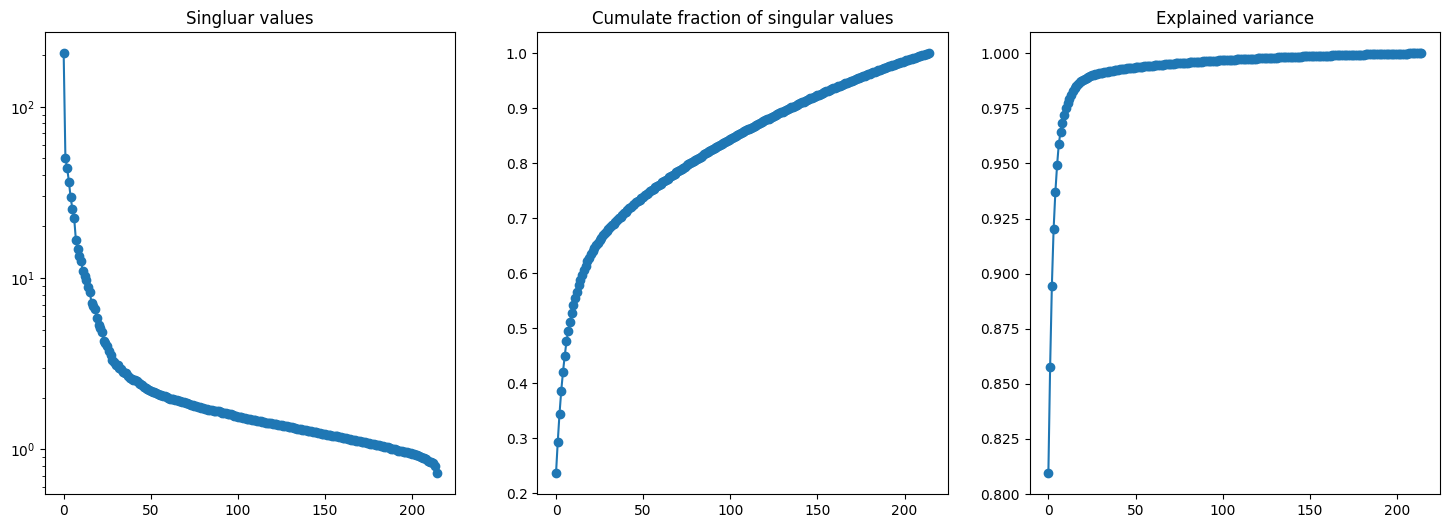

In [19]:
# PCA via exact SVD / plot the trend of values sigma_i

# First center the data
A_mean = np.mean(A, axis=1)
A_bar = A - A_mean[:, np.newaxis]

U, s, VT = np.linalg.svd(A_bar, full_matrices = False)
s = s[:-1]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,6))
axes[0].semilogy(s, 'o-')
axes[0].set_title('Singluar values')
axes[1].plot(np.cumsum(s)/np.sum(s), 'o-')
axes[1].set_title('Cumulate fraction of singular values')
axes[2].plot(np.cumsum(s**2)/np.sum(s**2), 'o-')
axes[2].set_title('Explained variance')

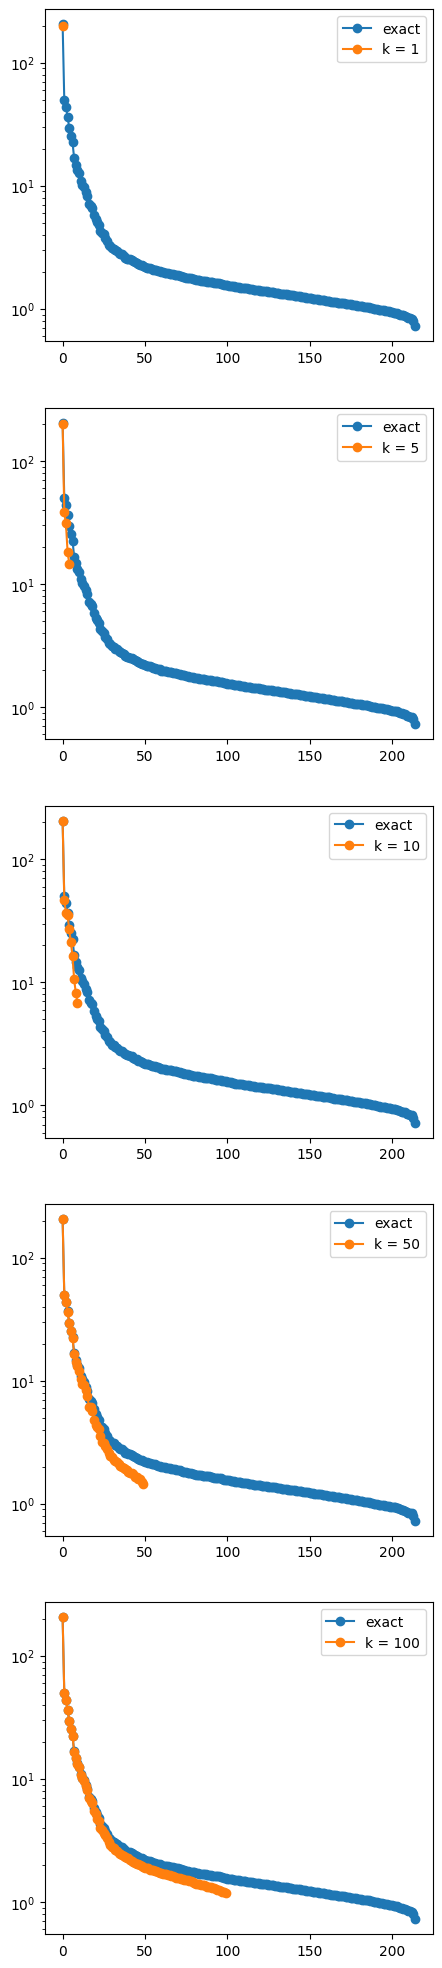

In [20]:
# plot for randomized SVD as k = {1, 5, 10, 50, 100}

K = [1, 5, 10, 50, 100]
store_rs = list()
for k in K:
  _, rs, _ = randomized_SVD(A_bar, k)
  store_rs.append(rs)

fig, axs = plt.subplots(nrows=len(K), ncols=1, figsize = (5,25))

for i in range(len(K)):
  axs[i].plot(s, 'o-', label = "exact")
  axs[i].semilogy(store_rs[i], 'o-', label = "k = %d" %K[i])
  axs[i].legend()


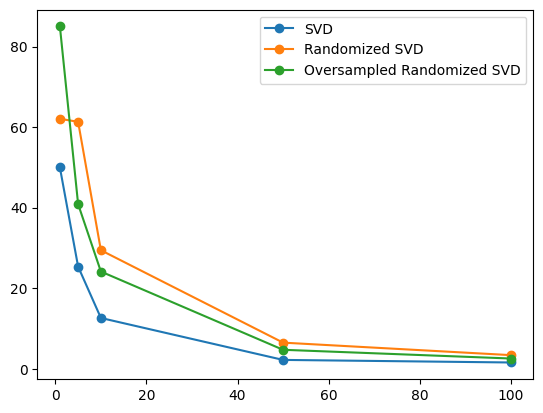

In [23]:
# use PCA with exact SVD to perform dimensionality reduction and compute the reconstruction error of the dataset as a function of k

# Exact SVD
U, s, VT = np.linalg.svd(A_bar, full_matrices=False)

reconstruction_error_SVD = list()

for k in K:
    A_k = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]
    reconstruction_error_SVD.append(np.linalg.norm(A_bar - A_k, ord=2))

# Randomized SVD
reconstruction_error_RSVD = list()
for k in K:
    rU, rs, rVT = randomized_SVD(A_bar, k)
    A_k = rU @ np.diag(rs) @ rVT
    reconstruction_error_RSVD.append(np.linalg.norm(A_bar - A_k, ord=2))

# Randomized SVD with oversampling
reconstruction_error_RSVD_oversampling = list()
for k in K:
    rU, rs, rVT = randomized_SVD(A_bar, round(1.5*k))
    A_k = rU @ np.diag(rs) @ rVT
    reconstruction_error_RSVD_oversampling.append(np.linalg.norm(A_bar - A_k, ord=2))

# Plot the trend of the reconstruction error of the dataset as a function of k in the above 3 cases
plt.plot(K, reconstruction_error_SVD, 'o-', label = "SVD")
plt.plot(K, reconstruction_error_RSVD, 'o-', label = "Randomized SVD")
plt.plot(K, reconstruction_error_RSVD_oversampling, 'o-', label = "Oversampled Randomized SVD")
plt.legend()

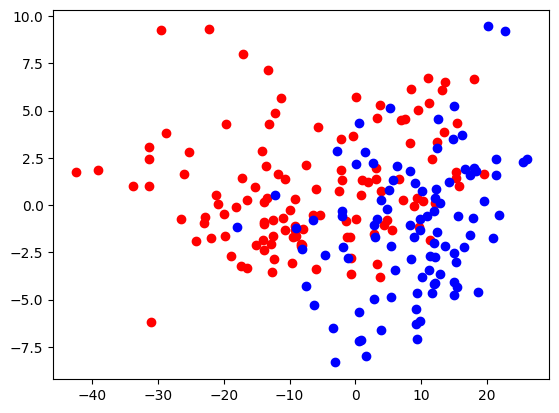

In [26]:
# make a scatterplot of the first two principal components (from exact SVD) plotting in red the group 'cancer' and in blue the other one.
PHI = U.T @ A_bar
plt.plot(PHI[0, grp == "Cancer"], PHI[1, grp == "Cancer"], "o", label="Cancer", color="red")
plt.plot(PHI[0, grp == "Normal"], PHI[1, grp == "Normal"], "o", label="Normal", color="blue")

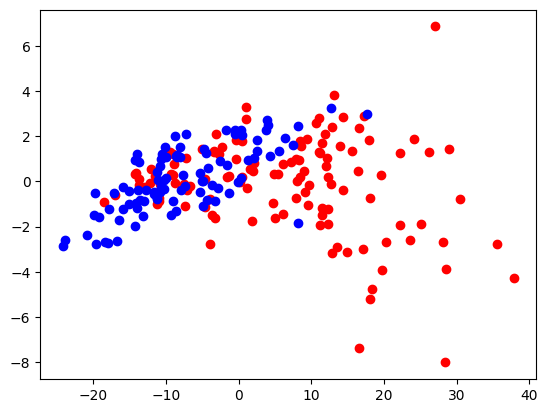

In [27]:
# repeat with Randomized SVD assuming k = 2
rU, rs, rVT = randomized_SVD(A_bar, 2)
PHI = rU.T @ A_bar
plt.plot(PHI[0, grp == "Cancer"], PHI[1, grp == "Cancer"], "o", label="Cancer", color="red")
plt.plot(PHI[0, grp == "Normal"], PHI[1, grp == "Normal"], "o", label="Normal", color="blue")

In [28]:
# compare computational time
import time

# exact SVD
t0 = time.time()
U, s, VT = np.linalg.svd(A_bar, full_matrices=False)
t1 = time.time()
print("Exact SVD took %f seconds" % (t1 - t0))

# randomized SVD
t2 = time.time()
rU, rs, rVT = randomized_SVD(A_bar, 2)
t3 = time.time()
print("Randomized SVD took %f seconds" % (t3 - t2))

# as expected, Randomized SVD is much faster than the classical one

Exact SVD took 0.107877 seconds
Randomized SVD took 0.004634 seconds
